In [1]:
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import h5py
import json
import pickle
import glob

In [2]:
file_list = []
for file in glob.glob(r"C:\LINHC\VersucheDBs\Trelleborg\2021-01-27-V24\*\*.h5"):
    file_list.append(file)
file_list

['C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM2.h5',
 'C:\\LINHC\\VersucheDBs

20210218_5_Phase_A-D_LEM1
ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>
Points:
(1069543,)
shift_opts_freqs_all:
(121, 1069543)


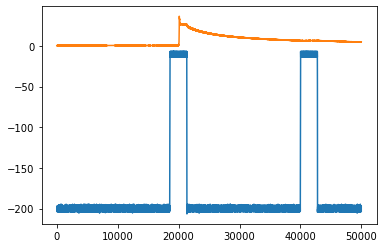

In [3]:
# choose 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5'
file = file_list[6]
filename = file.split('\\')[-1][:-3]
pklName = './data/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")

print(filename)
print("ATTR:")
print(h51.attrs.keys())
print("Keys:")
print(h51.keys())
print("Points:")
print(h51['t'].shape)
print("shift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)

plt.plot(h51['spd1'][:50000], label = 'spd')
plt.plot(h51['ip1k1'][:50000], label = 'ip1k1')
# plt.legend()

In [4]:
low = np.where(h51['spd1'][:]>-50)[0]
# skip the lsa in first 10000 points because some wierd patterns in speed, 
# check 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5', 
if filename in ['20210127_Phase_A-D_LEM2']:
    low = low[low>10000]
pos_low = h51['pos1'][low]
low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
pos_low_sep = np.split(pos_low,low_sep+1)
Ls = np.append(low[low_sep],low[-1])
Fs = np.append(low[0],low[low_sep+1])
if filename in ["20210218_7_Phase_C-F_LEM1","20210218_7_Phase_C-F_LEM2"]:
    Ls = Ls[:-1]
    Fs = Fs[:-1]

In [5]:
pklName = './data/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb'))
shift_opts_freqs_all.shape

(121, 1069543)

## Training

In [13]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)
    
X = np.asarray(dataset).T
y = np.asarray(h51['ip1k1'][N:])
print("X:")
print(X.shape)
print("y:")
print(y.shape)

X:
(1069443, 242)
y:
(1069443,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
# Training with random selected hyperparameters
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10 ,min_samples_leaf=10 ,oob_score=True,random_state=42)
rf.fit(X_train_scaled, y_train) # trainig time for 10 trees: >2h
print("RandomForestRegressor, oob score:", rf.oob_score_)

RandomForestRegressor, oob score: 0.8300110398226828


In [27]:
# save the file
modelName = './models/rf_ip1k1_' + filename + '.pkl'
pickle.dump(rf, open(modelName, 'wb'))

In [21]:
# # load the model from disk
# modelName = './models/rf_ip1k1_' + filename + '.pkl'
# rf = pickle.load(open(modelName, 'rb'))

In [28]:
rf.score(X_test_scaled, y_test)

0.836252366210232

In [50]:
err = abs(rf.predict(X_test_scaled) - y_test)
print("mean of the errors: ", np.mean(err))
print("median of the errors: ", np.median(err))
print("std of the errors: ", np.std(err))
plt.plot(err,'.')

mean of the errors:  0.25194142308910156
median of the errors:  0.13999187105705668
std of the errors:  0.6772990956943045


No handles with labels found to put in legend.
<ipython-input-45-e44d153d548d>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


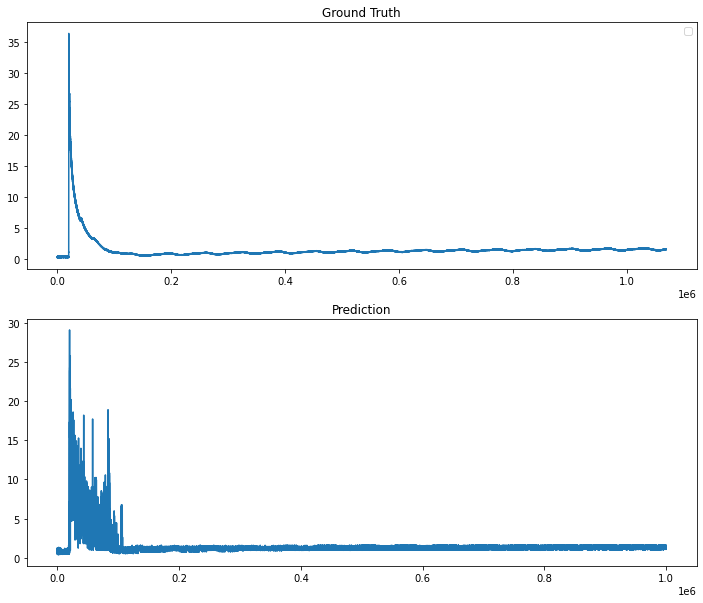

In [45]:
# predictioin vs ground truth
X_ = scaler.fit_transform(X[:int(1e6)])
y_ = rf.predict(X_)
%matplotlib inline
plt.figure(figsize = (12,10))
plt.subplot(211)
plt.legend()
ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(212, )
ax1.plot(y[:int(1e6)],label = 'ground truth')
ax1.title.set_text('Ground Truth')
ax2.plot(y_,label = 'predict')
ax2.title.set_text('Prediction')

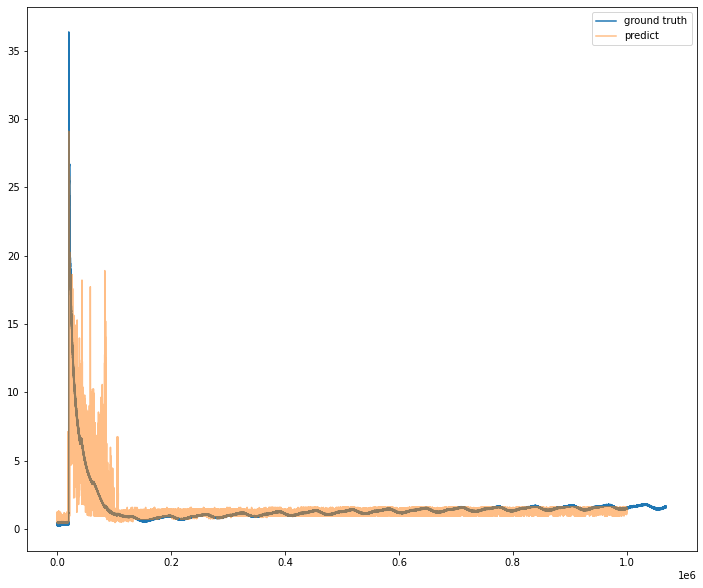

In [48]:
# predictioin vs ground truth in one plot
%matplotlib inline
fig = plt.figure(figsize =(12,10))
ax = fig.add_subplot(111)
ax.plot(y,label = 'ground truth')
ax.plot(y_, label = 'predict', alpha = 0.5)
plt.legend()

In [31]:
feature_lookup_rev = {}
for i in range(121*2):
    if i%2==0:
        feature_lookup_rev[i] = 's21-'+str(i//2)+'-real'
    else:
        feature_lookup_rev[i] = 's21-'+str(i//2)+'-imag' 

In [32]:
# feature ranking
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(X_train_scaled.shape[1]):
    print("%d. feature %d, %s :(%f)" % 
          (i + 1, indices[i],feature_lookup_rev[indices[i]], importances[indices[i]]))

Feature ranking:
1. feature 84, s21-42-real :(0.466820)
2. feature 68, s21-34-real :(0.128074)
3. feature 78, s21-39-real :(0.024458)
4. feature 77, s21-38-imag :(0.016406)
5. feature 64, s21-32-real :(0.014369)
6. feature 124, s21-62-real :(0.013534)
7. feature 138, s21-69-real :(0.012679)
8. feature 14, s21-7-real :(0.012370)
9. feature 161, s21-80-imag :(0.010671)
10. feature 71, s21-35-imag :(0.010232)
11. feature 63, s21-31-imag :(0.008888)
12. feature 120, s21-60-real :(0.006060)
13. feature 20, s21-10-real :(0.006007)
14. feature 127, s21-63-imag :(0.005905)
15. feature 38, s21-19-real :(0.005626)
16. feature 23, s21-11-imag :(0.005430)
17. feature 4, s21-2-real :(0.005272)
18. feature 215, s21-107-imag :(0.005199)
19. feature 174, s21-87-real :(0.005040)
20. feature 59, s21-29-imag :(0.004964)
21. feature 9, s21-4-imag :(0.004774)
22. feature 102, s21-51-real :(0.004648)
23. feature 3, s21-1-imag :(0.004556)
24. feature 224, s21-112-real :(0.004202)
25. feature 74, s21-37-real 

<IPython.core.display.Javascript object>


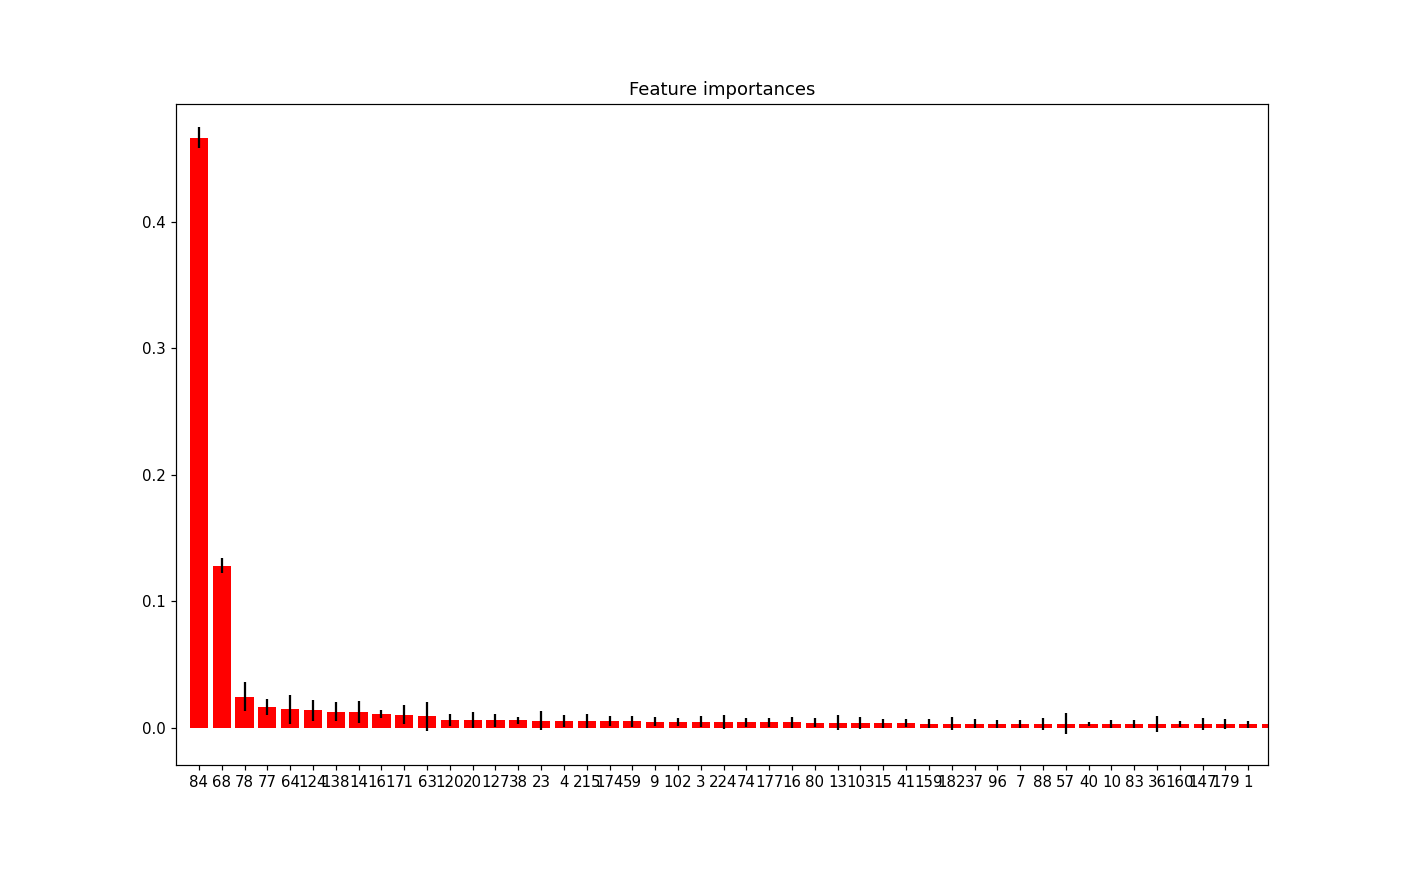

In [51]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Plot the impurity-based feature importances of the forest
%matplotlib nbagg
plt.figure(figsize = (8,6))
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

## Hyperparameter tuning

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

### Preprocessing

In [7]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)

X = np.asarray(dataset).T
y = np.asarray(h51['ip1k1'][N:])
print("X:")
print(X.shape)
print("y:")
print(y.shape)

h51.close() 

X:
(1069443, 242)
y:
(1069443,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_val.shape)

(106945, 242)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### n_estimators

In [ ]:
param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,random_state=42), 
                       param_grid = param_test1, scoring=('r2', 'neg_mean_squared_error'),cv=5, refit='neg_mean_squared_error')
gsearch1.fit(X_val_scaled,y_val)

In [87]:
df1 = pd.DataFrame.from_dict(gsearch1.cv_results_)
df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,6.346879,0.180964,0.027737,0.004729,10,{'n_estimators': 10},0.614495,0.619224,0.657667,0.669084,...,0.026649,10,-1.401205,-1.221174,-1.004760,-1.104332,-0.975502,-1.141394,0.155839,10
1,12.569443,0.205793,0.053301,0.008374,20,{'n_estimators': 20},0.616211,0.624649,0.658431,0.668113,...,0.024684,9,-1.394969,-1.203774,-1.002517,-1.107570,-0.979115,-1.137589,0.151581,9
2,19.209230,1.015162,0.084010,0.018762,30,{'n_estimators': 30},0.619828,0.630946,0.664859,0.666658,...,0.023329,8,-1.381824,-1.183582,-0.983648,-1.112427,-0.972984,-1.126893,0.150080,8
3,28.873032,0.812430,0.122767,0.007420,40,{'n_estimators': 40},0.621840,0.629723,0.666197,0.669687,...,0.023713,7,-1.374509,-1.187503,-0.979723,-1.102320,-0.970709,-1.122953,0.149376,7
4,35.367977,0.146603,0.145978,0.002628,50,{'n_estimators': 50},0.622709,0.633327,0.668683,0.673129,...,0.023792,5,-1.371349,-1.175945,-0.972426,-1.090833,-0.966754,-1.115461,0.149878,5
5,41.856360,0.211948,0.175389,0.009617,60,{'n_estimators': 60},0.623059,0.633375,0.667848,0.673356,...,0.023488,6,-1.370079,-1.175791,-0.974878,-1.090075,-0.968673,-1.115899,0.148609,6
6,49.070134,0.212133,0.196553,0.003951,70,{'n_estimators': 70},0.626187,0.635053,0.667681,0.673525,...,0.022299,4,-1.358709,-1.170411,-0.975367,-1.089509,-0.968622,-1.112523,0.144227,4
7,56.745523,0.644497,0.229845,0.009354,80,{'n_estimators': 80},0.626640,0.635942,0.667455,0.673581,...,0.022048,2,-1.357061,-1.167559,-0.976030,-1.089324,-0.967809,-1.111557,0.143481,2
8,62.882619,0.220544,0.258338,0.013838,90,{'n_estimators': 90},0.626442,0.634858,0.666735,0.673213,...,0.022428,3,-1.357783,-1.171035,-0.978143,-1.090550,-0.964847,-1.112472,0.144170,3
9,64.679565,4.303080,0.223919,0.030199,100,{'n_estimators': 100},0.626396,0.636591,0.667604,0.674119,...,0.022497,1,-1.357949,-1.165476,-0.975591,-1.087528,-0.962476,-1.109804,0.144838,1


In [94]:
df1[['params','mean_test_neg_mean_squared_error','std_test_neg_mean_squared_error']]

,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error
0,{'n_estimators': 10},-1.141394,0.155839
1,{'n_estimators': 20},-1.137589,0.151581
2,{'n_estimators': 30},-1.126893,0.150080
3,{'n_estimators': 40},-1.122953,0.149376
4,{'n_estimators': 50},-1.115461,0.149878
5,{'n_estimators': 60},-1.115899,0.148609
6,{'n_estimators': 70},-1.112523,0.144227
7,{'n_estimators': 80},-1.111557,0.143481
8,{'n_estimators': 90},-1.112472,0.144170
9,{'n_estimators': 100},-1.109804,0.144838


In [93]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 100}, -1.1098040890352108)

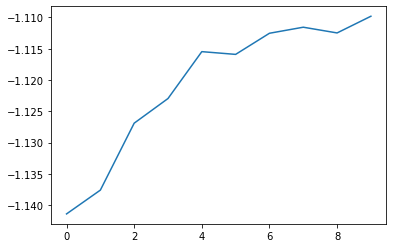

In [99]:
%matplotlib inline
plt.plot(param_test1['n_estimators'],df1['mean_test_neg_mean_squared_error'])

### max_depth

In [15]:
param_test2 = {'max_depth':range(2,14,2)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 50, min_samples_split=100,
                                                          min_samples_leaf=20,oob_score=True, random_state=42), 
                       param_grid = param_test2, scoring=('r2','neg_mean_squared_error'),cv=5, refit='neg_mean_squared_error')
gsearch2.fit(X_val_scaled,y_val)
df2 = pd.DataFrame.from_dict(gsearch2.cv_results_)
df2[['params','mean_test_neg_mean_squared_error','std_test_neg_mean_squared_error']]

NameError: name 'gsearch2' is not defined

In [ ]:
%matplotlib inline
plt.plot(param_test2['max_depth'],df2['mean_test_neg_mean_squared_error'])

In [13]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 12}, -0.8523503921102936)

### min_samples_split

In [13]:
param_test3 = {'min_samples_split':[10,50,100,150,200]}
gsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 50, max_depth = 10,
                                                          min_samples_leaf=20,oob_score=True, random_state=42), 
                       param_grid = param_test3, scoring=('r2','neg_mean_squared_error'),cv=5, refit='neg_mean_squared_error')
gsearch3.fit(X_val_scaled,y_val)
df3 = pd.DataFrame.from_dict(gsearch3.cv_results_)
df3[['params','mean_test_neg_mean_squared_error','std_test_neg_mean_squared_error']]

,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error
0,{'min_samples_split': 10},-0.828602,0.122095
1,{'min_samples_split': 50},-0.841945,0.124136
2,{'min_samples_split': 100},-0.894767,0.130822
3,{'min_samples_split': 150},-0.936905,0.133016
4,{'min_samples_split': 200},-0.970613,0.137235


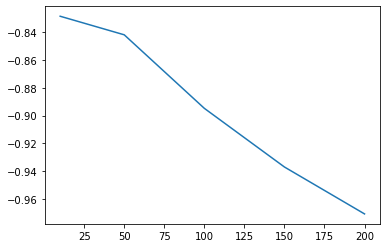

In [18]:
%matplotlib inline
plt.plot(param_test3['min_samples_split'],df3['mean_test_neg_mean_squared_error'])

In [19]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_split': 10}, -0.8286024953011552)

### min_samples_leaf

In [18]:
param_test4 = {'min_samples_leaf':[10,50,100,150,200]}
gsearch4 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 50, max_depth = 10, min_samples_split= 50,
                                                          oob_score=True, random_state=42), 
                       param_grid = param_test4, scoring=('r2','neg_mean_squared_error'),cv=5, refit='neg_mean_squared_error')
gsearch4.fit(X_val_scaled,y_val)
df4 = pd.DataFrame.from_dict(gsearch4.cv_results_)
df4
# df4[['params','mean_test_neg_mean_squared_error','std_test_neg_mean_squared_error']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,629.685870,39.280401,0.146421,0.019080,10,{'min_samples_leaf': 10},0.719007,0.728740,0.756404,0.762413,...,0.019615,1,-1.021333,-0.869949,-0.714964,-0.792874,-0.705726,-0.820969,0.116492,1
1,659.668208,12.359453,0.154205,0.020051,50,{'min_samples_leaf': 50},0.674785,0.690119,0.727645,0.730526,...,0.025229,2,-1.182067,-0.993807,-0.799371,-0.899286,-0.796968,-0.934300,0.143681,2
2,514.916308,11.744636,0.117025,0.015054,100,{'min_samples_leaf': 100},0.644015,0.656196,0.693642,0.693496,...,0.024463,3,-1.293908,-1.102602,-0.899170,-1.022864,-0.892717,-1.042252,0.148447,3
3,493.824701,2.837508,0.108999,0.001787,150,{'min_samples_leaf': 150},0.620723,0.631107,0.664860,0.664853,...,0.022574,4,-1.378570,-1.183063,-0.983645,-1.118452,-0.976265,-1.127999,0.148169,4
4,507.661668,10.567366,0.116839,0.007529,200,{'min_samples_leaf': 200},0.598750,0.611750,0.642405,0.638324,...,0.022626,5,-1.458437,-1.245142,-1.049551,-1.206984,-1.032044,-1.198432,0.154731,5


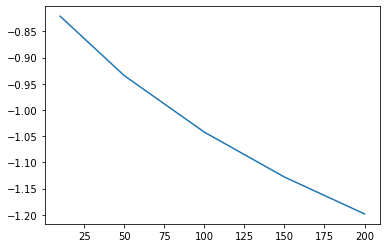

In [13]:
%matplotlib inline
plt.plot(param_test4['min_samples_leaf'],df4['mean_test_neg_mean_squared_error'])

In [14]:
gsearch4.best_params_, gsearch4.best_score_

({'min_samples_leaf': 10}, -0.820969139418146)

### Combination

In [14]:
from sklearn.model_selection import RandomizedSearchCV
param_test_combi = {
    'max_depth': [8, 10, 16],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 4, 8, 10],
    'min_samples_split': [2, 4, 8, 10],
    'n_estimators': [50,80,100]
}

gsearch_combi = RandomizedSearchCV(estimator = RandomForestRegressor(oob_score=True,random_state=42), n_iter = 20,
                                   param_distributions = param_test_combi,verbose = 2, scoring=('r2','neg_mean_squared_error'),cv=3, refit='neg_mean_squared_error')
gsearch_combi.fit(X_val_scaled,y_val)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=  23.2s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=  22.9s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=  22.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=14.1min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=14.0min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=14.2min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=80; total time=  45.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=80; 

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(oob_score=True,
                                                   random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [8, 10, 16],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 8, 10],
                                        'min_samples_split': [2, 4, 8, 10],
                                        'n_estimators': [50, 80, 100]},
                   refit='neg_mean_squared_error',
                   scoring=('r2', 'neg_mean_squared_error'), verbose=2)

In [15]:
df_combi = pd.DataFrame.from_dict(gsearch_combi.cv_results_)
df_combi
# df_combi[['params','mean_test_neg_mean_squared_error','std_test_neg_mean_squared_error']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,...,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,22.964578,0.164674,0.141333,0.001247,50,10,8,sqrt,8,"{'n_estimators': 50, 'min_samples_split': 10, ...",...,0.705553,0.686447,0.022990,19,-1.226568,-0.911297,-0.918848,-1.018904,0.146873,19
1,844.820921,5.520095,0.362340,0.024728,100,10,4,auto,10,"{'n_estimators': 100, 'min_samples_split': 10,...",...,0.772162,0.766716,0.013828,10,-0.894593,-0.666782,-0.710989,-0.757455,0.098636,10
2,44.959927,0.071030,0.260527,0.003992,80,4,4,sqrt,10,"{'n_estimators': 80, 'min_samples_split': 4, '...",...,0.753388,0.735430,0.023085,12,-1.053772,-0.758409,-0.769577,-0.860586,0.136679,12
3,959.700139,7.427610,0.484242,0.012059,80,10,4,auto,16,"{'n_estimators': 80, 'min_samples_split': 10, ...",...,0.833884,0.824452,0.019288,1,-0.717846,-0.479729,-0.518381,-0.571985,0.104339,1
4,554.604319,0.846407,0.256995,0.027714,80,8,8,auto,8,"{'n_estimators': 80, 'min_samples_split': 8, '...",...,0.722128,0.716155,0.011742,15,-1.064729,-0.829640,-0.867123,-0.920497,0.103129,15
5,616.939700,9.468134,0.305209,0.004509,50,10,2,auto,16,"{'n_estimators': 50, 'min_samples_split': 10, ...",...,0.829071,0.823352,0.020952,3,-0.725849,-0.468295,-0.533400,-0.575848,0.109346,3
6,50.117125,3.430046,0.293578,0.014054,80,4,10,sqrt,10,"{'n_estimators': 80, 'min_samples_split': 4, '...",...,0.738362,0.721155,0.021522,13,-1.096435,-0.806254,-0.816466,-0.906385,0.134450,13
7,426.374690,20.791247,0.265879,0.050909,50,10,10,auto,8,"{'n_estimators': 50, 'min_samples_split': 10, ...",...,0.716567,0.712588,0.012380,18,-1.078621,-0.833353,-0.884479,-0.932151,0.105652,18
8,1040.667075,83.280047,0.443342,0.063347,100,2,2,auto,10,"{'n_estimators': 100, 'min_samples_split': 2, ...",...,0.772241,0.767469,0.014216,9,-0.893029,-0.661508,-0.710742,-0.755093,0.099585,9
9,43.633080,0.795500,0.298390,0.027359,50,2,4,sqrt,16,"{'n_estimators': 50, 'min_samples_split': 2, '...",...,0.806471,0.791889,0.022360,5,-0.850015,-0.579883,-0.603924,-0.677940,0.122070,5


In [16]:
gsearch_combi.best_params_, gsearch_combi.best_score_

({'n_estimators': 80,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': 'auto',
  'max_depth': 16},
 -0.5719852006573362)

## Training of RF with fine-tuned hyperparameters

In [17]:
# Training with fine-tuned best hyperparameters
rf = RandomForestRegressor(**gsearch_combi.best_params_,
                           oob_score=True,random_state=42)
rf.fit(X_train_scaled, y_train) # trainig time for 10 trees: >2h
print("RandomForestRegressor, oob score:", rf.oob_score_)

RandomForestRegressor, oob score: 0.9271449004734842


In [18]:
# save the file
modelName = './models/rf_ip1k1_' + filename + '_tuned.pkl'
pickle.dump(rf, open(modelName, 'wb'))

In [21]:
# # load the model from disk
# modelName = './models/rf_ip1k1_' + filename + '_tuned.pkl'
# rf = pickle.load(open(modelName, 'rb'))

In [19]:
rf.score(X_test_scaled, y_test)

0.9286301220603363

mean of the errors:  0.12839219290089326
median of the errors:  0.05599626258226453
std of the errors:  0.45947964472025865


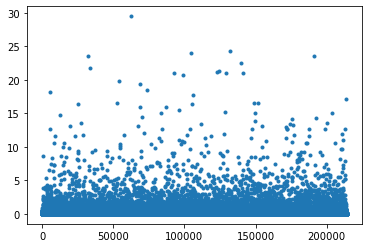

In [20]:
err = abs(rf.predict(X_test_scaled) - y_test)
print("mean of the errors: ", np.mean(err))
print("median of the errors: ", np.median(err))
print("std of the errors: ", np.std(err))
plt.plot(err,'.')

No handles with labels found to put in legend.
<ipython-input-21-4bdc2b648cbd>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


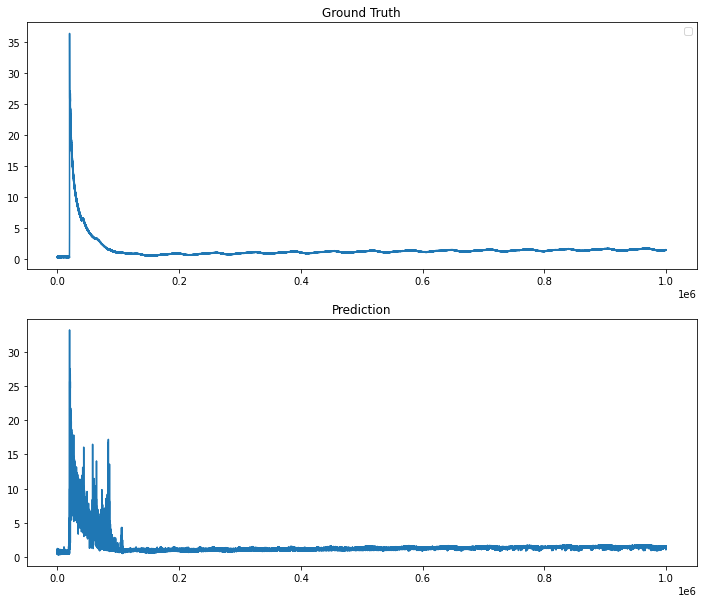

In [21]:
# predictioin vs ground truth
X_ = scaler.fit_transform(X[:int(1e6)])
y_ = rf.predict(X_)
%matplotlib inline
plt.figure(figsize = (12,10))
plt.subplot(211)
plt.legend()
ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(212, )
ax1.plot(y[:int(1e6)],label = 'ground truth')
ax1.title.set_text('Ground Truth')
ax2.plot(y_,label = 'predict')
ax2.title.set_text('Prediction')

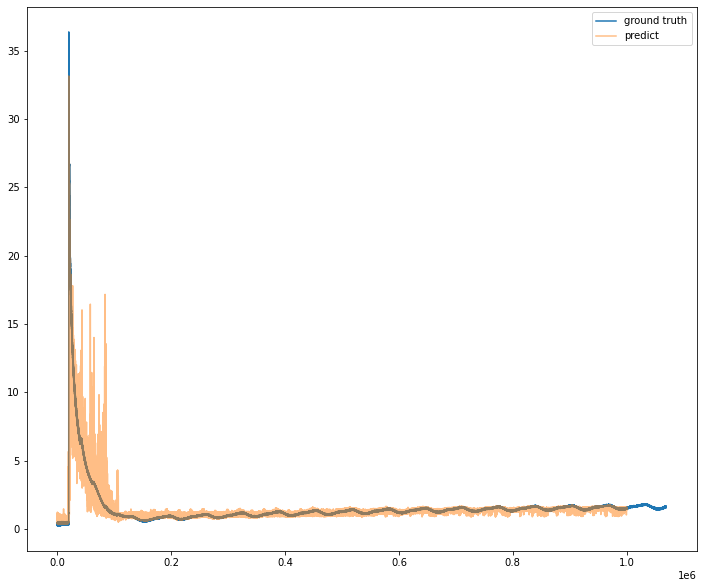

In [22]:
# predictioin vs ground truth in one plot
%matplotlib inline
fig = plt.figure(figsize =(12,10))
ax = fig.add_subplot(111)
ax.plot(y[:int(1e6)],label = 'ground truth')
ax.plot(y_, label = 'predict', alpha = 0.5)
plt.legend()

In [23]:
feature_lookup_rev = {}
for i in range(121*2):
    if i%2==0:
        feature_lookup_rev[i] = 's21-'+str(i//2)+'-real'
    else:
        feature_lookup_rev[i] = 's21-'+str(i//2)+'-imag' 

In [24]:
# feature ranking
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(X_train_scaled.shape[1]):
    print("%d. feature %d, %s :(%f)" % 
          (i + 1, indices[i],feature_lookup_rev[indices[i]], importances[indices[i]]))

Feature ranking:
1. feature 84, s21-42-real :(0.397319)
2. feature 68, s21-34-real :(0.107862)
3. feature 78, s21-39-real :(0.024679)
4. feature 124, s21-62-real :(0.017699)
5. feature 77, s21-38-imag :(0.014702)
6. feature 64, s21-32-real :(0.014254)
7. feature 138, s21-69-real :(0.013205)
8. feature 14, s21-7-real :(0.012687)
9. feature 161, s21-80-imag :(0.011006)
10. feature 71, s21-35-imag :(0.008633)
11. feature 120, s21-60-real :(0.007529)
12. feature 23, s21-11-imag :(0.007339)
13. feature 63, s21-31-imag :(0.006560)
14. feature 127, s21-63-imag :(0.006406)
15. feature 102, s21-51-real :(0.005995)
16. feature 4, s21-2-real :(0.005958)
17. feature 182, s21-91-real :(0.005859)
18. feature 9, s21-4-imag :(0.005541)
19. feature 38, s21-19-real :(0.005535)
20. feature 174, s21-87-real :(0.005366)
21. feature 59, s21-29-imag :(0.005316)
22. feature 74, s21-37-real :(0.005259)
23. feature 123, s21-61-imag :(0.004554)
24. feature 80, s21-40-real :(0.004436)
25. feature 103, s21-51-imag

<IPython.core.display.Javascript object>


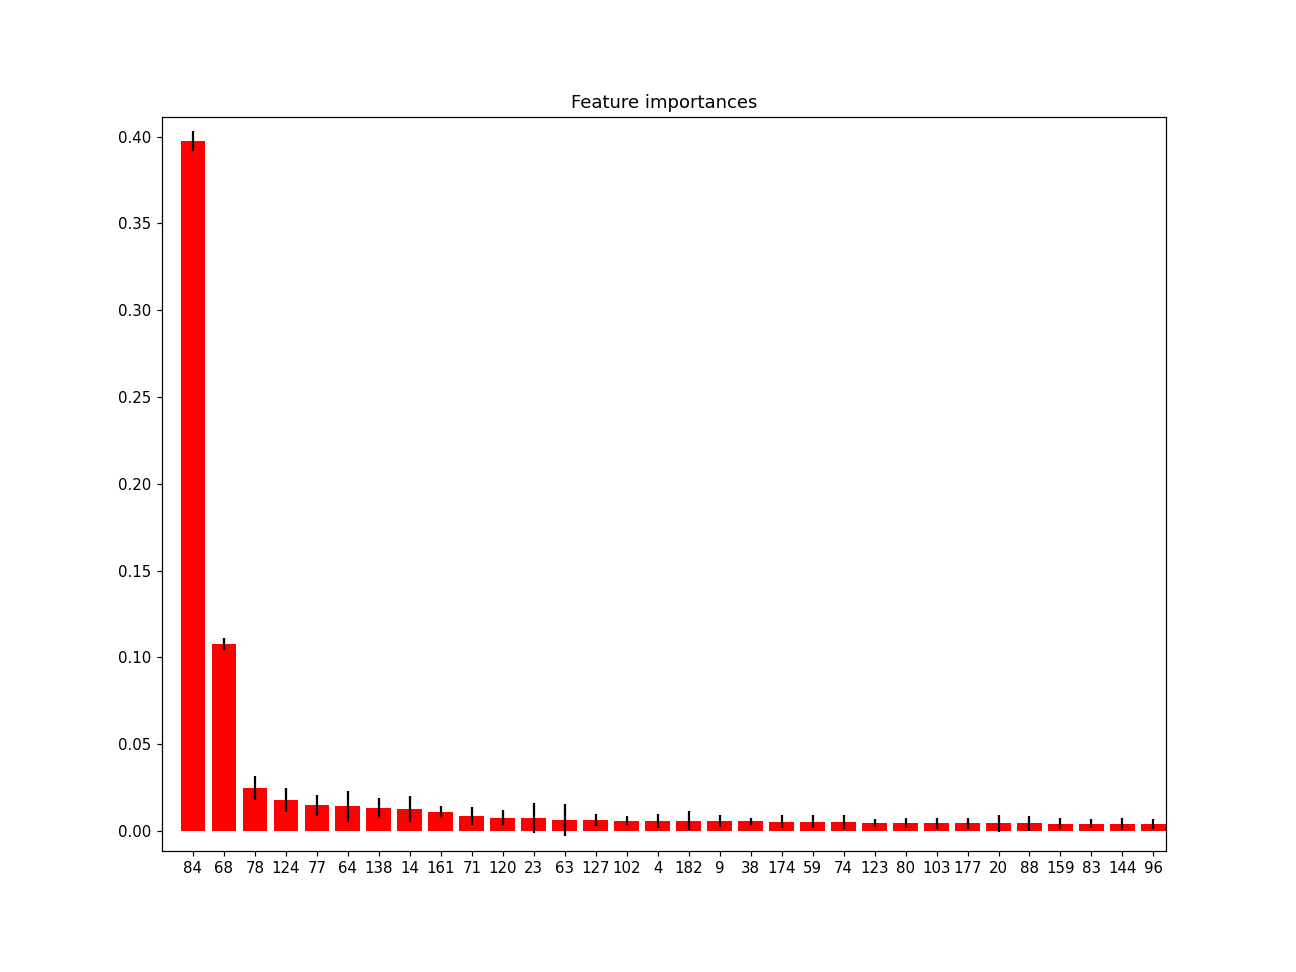

In [25]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Plot the impurity-based feature importances of the forest
%matplotlib nbagg
plt.figure(figsize = (8,6))
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

## Training of RF considering tradeoff between performance, speed and storage

In [ ]:
# # Training with fine-tuned hyperparameters considering tradeoff between performance and speed
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators=50, 
#                            max_depth=10, 
#                            min_samples_split=10 ,
#                            min_samples_leaf=10 ,
#                            oob_score=True,random_state=42)
# rf.fit(X_train_scaled, y_train) # trainig time for 10 trees: >2h
# print("RandomForestRegressor, oob score:", rf.oob_score_)

In [ ]:
# save the file
modelName = './models/rf_ip1k1_' + filename + '_tuned_tradeoff.pkl'
pickle.dump(rf, open(modelName, 'wb'))

In [21]:
# # load the model from disk
# modelName = './models/rf_ip1k1_' + filename + '_tuned.pkl'
# rf = pickle.load(open(modelName, 'rb'))

In [ ]:
rf.score(X_test_scaled, y_test)

In [ ]:
err = abs(rf.predict(X_test_scaled) - y_test)
print("mean of the errors: ", np.mean(err))
print("median of the errors: ", np.median(err))
print("std of the errors: ", np.std(err))
plt.plot(err,'.')

In [ ]:
# predictioin vs ground truth
X_ = scaler.fit_transform(X[:int(1e6)])
y_ = rf.predict(X_)
%matplotlib inline
plt.figure(figsize = (12,10))
plt.subplot(211)
plt.legend()
ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(212, )
ax1.plot(y[:int(1e6)],label = 'ground truth')
ax1.title.set_text('Ground Truth')
ax2.plot(y_,label = 'predict')
ax2.title.set_text('Prediction')

In [ ]:
# predictioin vs ground truth in one plot
%matplotlib inline
fig = plt.figure(figsize =(12,10))
ax = fig.add_subplot(111)
ax.plot(y,label = 'ground truth')
ax.plot(y_, label = 'predict', alpha = 0.5)
plt.legend()

In [ ]:
feature_lookup_rev = {}
for i in range(121*2):
    if i%2==0:
        feature_lookup_rev[i] = 's21-'+str(i//2)+'-real'
    else:
        feature_lookup_rev[i] = 's21-'+str(i//2)+'-imag' 

In [ ]:
# feature ranking
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(X_train_scaled.shape[1]):
    print("%d. feature %d, %s :(%f)" % 
          (i + 1, indices[i],feature_lookup_rev[indices[i]], importances[indices[i]]))

In [ ]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Plot the impurity-based feature importances of the forest
%matplotlib nbagg
plt.figure(figsize = (8,6))
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()